<a href="https://colab.research.google.com/github/SophieShin/DeepLearning/blob/main/%5BSSH%5Dlab05_autograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5 – Autograd

Before working on this notebook:
  - Create a copy in your drive
  - Set your Runtime to None

Adapted from: [Original Source](https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqa2IzMmVuNGxhUm9XcnN1UXVydWVjZEpkaEJvd3xBQ3Jtc0ttTkp6Tml1MzlqT1Fia3dFNTdteFVlbW5BVGxDNzMxZW51YzVnTUR6cURhOU1TRHdqQmtUaWZfekppMkswUm52SUZ6d285SHA5YVdfMHF3WmhyYWZuODNER0trLTUyM3VQNHpCcnEtakZxWXMwNXI1RQ&q=https%3A%2F%2Fpytorch-tutorial-assets.s3.amazonaws.com%2Fyoutube-series%2FVideo%2B3%2B-%2BAutograd.ipynb)

PyTorch's *Autograd* feature is part of what make PyTorch flexible and fast for building machine learning projects. It allows for the rapid and easy computation of multiple partial derivatives (also referred to as *gradients)* over a complex computation. This operation is central to backpropagation-based neural network learning.

The power of autograd comes from the fact that it traces your computation dynamically *at runtime,* meaning that if your model has decision branches, or loops whose lengths are not known until runtime, the computation will still be traced correctly, and you'll get correct gradients to drive learning. This, combined with the fact that your models are built in Python, offers far more flexibility than frameworks that rely on static analysis of a more rigidly-structured model for computing gradients.

## What Do We Need Autograd For?

In training a model, we want to minimize the loss, $L$. In the idealized case of a perfect model, that means adjusting its learning weights - that is, the adjustable parameters of the function - such that loss is zero for all inputs. In the real world, it means an iterative process of nudging the learning weights until we see that we get a tolerable loss for a wide variety of inputs.

How do we decide how far and in which direction to nudge the weights? We want to *minimize* the loss, which means making its first derivative with respect to the input equal to 0: $\frac{\partial L}{\partial x} = 0$.

Recall, though, that the loss is not *directly* derived from the input, but a function of the model's output (which is a function of the input directly). By the chain rule of differential calculus, we have $\frac{\partial {L({\vec y})}}{\partial x}$ = $\frac{\partial L}{\partial y}\frac{\partial y}{\partial x}$ = $\frac{\partial L}{\partial y}\frac{\partial M(x)}{\partial x}$.

$\frac{\partial M(x)}{\partial x}$ is where things get complex. The partial derivatives of the model's outputs with respect to its inputs, if we were to expand the expression using the chain rule again, would involve many local partial derivatives over every multiplied learning weight, every activation function, and every other mathematical transformation in the model. The full expression for each such partial derivative is the sum of the products of the local gradient of *every possible path* through the computation graph that ends with the variable whose gradient we are trying to measure.

In particular, the gradients over the learning weights are of interest to us - they tell us *what direction to change each weight* to get the loss function closer to zero.

Since the number of such local derivatives (each corresponding to a separate path through the model's computation graph) will tend to go up exponentially with the depth of a neural network, so does the complexity in computing them. This is where autograd comes in: It tracks the history of every computation. Every computed tensor in your PyTorch model carries a history of its input tensors and the function used to create it. Combined with the fact that PyTorch functions meant to act on tensors each have a built-in implementation for computing their own derivatives, this greatly speeds the computation of the local derivatives needed for learning.

## A Simple Example

Let's start with a straightforward example. First, we'll do some imports to let us graph our results:

In [ ]:
%matplotlib inline
# Jupyer notebook을 실행한 브라우저에서 그림을 볼 수  있도록,
# 브라우저 내부(Inline)에 그려지도록 하는 코드

In [ ]:
import torch

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

Next, we'll create an input tensor full of evenly spaced values on the interval $[0, 2{\pi}]$, and specify `requires_grad=True`. (Like most functions that create tensors, `torch.linspace()` accepts an optional `requires_grad` option.) Setting this flag means that in every computation that follows, autograd will be accumulating the history of the computation in the output tensors of that computation.

In [ ]:
a = torch.linspace(0., 2. * math.pi, steps = 25, requires_grad = True)
print(a)

tensor([0.0000, 0.2618, 0.5236, 0.7854, 1.0472, 1.3090, 1.5708, 1.8326, 2.0944,
        2.3562, 2.6180, 2.8798, 3.1416, 3.4034, 3.6652, 3.9270, 4.1888, 4.4506,
        4.7124, 4.9742, 5.2360, 5.4978, 5.7596, 6.0214, 6.2832],
       requires_grad=True)


In [ ]:
#Q1. What would happen if requires_grad is not set to True?
#A1. It then enables to compute the derivatives when backpropagation by storing computing history.

In [ ]:
aa= torch.linspace(0., 2. * math.pi, steps = 25, requires_grad = False)
print(aa)

tensor([0.0000, 0.2618, 0.5236, 0.7854, 1.0472, 1.3090, 1.5708, 1.8326, 2.0944,
        2.3562, 2.6180, 2.8798, 3.1416, 3.4034, 3.6652, 3.9270, 4.1888, 4.4506,
        4.7124, 4.9742, 5.2360, 5.4978, 5.7596, 6.0214, 6.2832])


Next, we'll perform a computation, and plot its output in terms of its inputs:

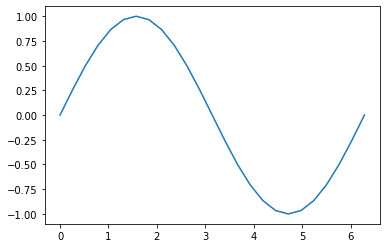

In [ ]:
b = torch.sin(a)
plt.plot(a.detach(), b.detach()) # can't call plot on tensors that require grads. Detach them first

Let's have a closer look at the tensor `b`. When we print it, we see an indicator that it is tracking its computation history:

In [ ]:
print(b)

tensor([ 0.0000e+00,  2.5882e-01,  5.0000e-01,  7.0711e-01,  8.6603e-01,
         9.6593e-01,  1.0000e+00,  9.6593e-01,  8.6603e-01,  7.0711e-01,
         5.0000e-01,  2.5882e-01, -8.7423e-08, -2.5882e-01, -5.0000e-01,
        -7.0711e-01, -8.6603e-01, -9.6593e-01, -1.0000e+00, -9.6593e-01,
        -8.6603e-01, -7.0711e-01, -5.0000e-01, -2.5882e-01,  1.7485e-07],
       grad_fn=<SinBackward0>)


In [ ]:
#Q2. What does the argument grad_fn=<SinBackward0> indicate here?
#A2. In order to be ready for the case of taking derivative, it stores the derivates of sin function.

Let's perform some more computations:

In [ ]:
c = 2 * b
print(f'c = {c}')

d = c + 1
print(f'd = {d}')

c = tensor([ 0.0000e+00,  5.1764e-01,  1.0000e+00,  1.4142e+00,  1.7321e+00,
         1.9319e+00,  2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,
         1.0000e+00,  5.1764e-01, -1.7485e-07, -5.1764e-01, -1.0000e+00,
        -1.4142e+00, -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00,
        -1.7321e+00, -1.4142e+00, -1.0000e+00, -5.1764e-01,  3.4969e-07],
       grad_fn=<MulBackward0>)
d = tensor([ 1.0000e+00,  1.5176e+00,  2.0000e+00,  2.4142e+00,  2.7321e+00,
         2.9319e+00,  3.0000e+00,  2.9319e+00,  2.7321e+00,  2.4142e+00,
         2.0000e+00,  1.5176e+00,  1.0000e+00,  4.8236e-01, -3.5763e-07,
        -4.1421e-01, -7.3205e-01, -9.3185e-01, -1.0000e+00, -9.3185e-01,
        -7.3205e-01, -4.1421e-01,  4.7684e-07,  4.8236e-01,  1.0000e+00],
       grad_fn=<AddBackward0>)


Finally, let's compute a single-element output. 

In [ ]:
out = d.sum()
print(out)

tensor(25., grad_fn=<SumBackward0>)


## Tracking the computations
Each `grad_fn` stored with our tensors allows you to walk the computation all the way back to its inputs with its `next_functions` property. We can see below that drilling down on this property on `d` shows us the gradient functions for all the prior tensors. Note that `a.grad_fn` is reported as `None`, indicating that this was an input to the function with no history of its own.

In [ ]:
print('d:')
print(d.grad_fn)
print(d.grad_fn.next_functions)
print(d.grad_fn.next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions)
print('\nc:')
print(c.grad_fn)
print('\nb:')
print(b.grad_fn)
print('\na:')
print(a.grad_fn)

d:
((<MulBackward0 object at 0x7f60d078b9d0>, 0), (None, 0))
((<SinBackward0 object at 0x7f60d078b890>, 0), (None, 0))
((<AccumulateGrad object at 0x7f60d078b8d0>, 0),)
()

c:

b:

a:
None


With all this machinery in place, how do we get derivatives out? You call the `backward()` method on the output, and check the input's `grad` property to inspect the gradients. When you call `.backward()` on a tensor with no arguments, it expects the calling tensor to contain only a single element, as is the case when computing a loss function.

tensor([ 2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,  1.0000e+00,
         5.1764e-01, -8.7423e-08, -5.1764e-01, -1.0000e+00, -1.4142e+00,
        -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00, -1.7321e+00,
        -1.4142e+00, -1.0000e+00, -5.1764e-01,  2.3850e-08,  5.1764e-01,
         1.0000e+00,  1.4142e+00,  1.7321e+00,  1.9319e+00,  2.0000e+00])


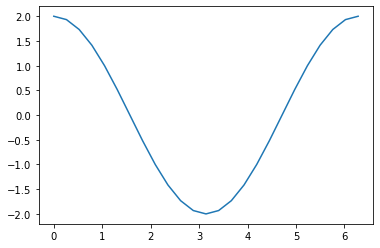

In [ ]:
out.backward()
print(a.grad)
plt.plot(a.detach(), a.grad.detach())

In [ ]:
print(d.grad)
# except a.grad, b/c/d.grad provide 'none'. Q. why??


None


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


In [ ]:
#Q3. What is the range of values of the gradients for this function?
#A3. It ranges from -2 to 2.

Recall the computation steps we took to get here:

```
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
b = torch.sin(a)
c = 2 * b
d = c + 1
out = d.sum()
```

Adding a constant, as we did to compute `d`, does not change the derivative. That leaves $c = 2 * b = 2 * sin(a)$, the derivative of which should be $2 * cos(a)$. Looking at the graph above, that's just what we see.

### Exercise

In [ ]:
# Q4. Create a tensor containing the numbers 0 to 4 (5 floats) and set it to keep track of the history of the computation in the output tensors
x = torch.linspace(0., 4., steps = 5, requires_grad = True)
print(x)

tensor([0., 1., 2., 3., 4.], requires_grad=True)


In [ ]:
y = x*x
print(y)

tensor([ 0.,  1.,  4.,  9., 16.], grad_fn=<MulBackward0>)


In [ ]:
y.backward()

RuntimeError: ignored

In [ ]:
# x.zero_grad()

# Q5. Create a new tensor y to be the dot product of x on itself. Use torch.dot()
y = torch.dot(x, x)

#print(y)
print(y)

# Q6. Calculate the gradient of y with respect to x by calling the function for backpropagation 
y.backward()

# Q7. Print the gradient
print(x.grad)


tensor(30., grad_fn=<DotBackward0>)
tensor([0., 2., 4., 6., 8.])


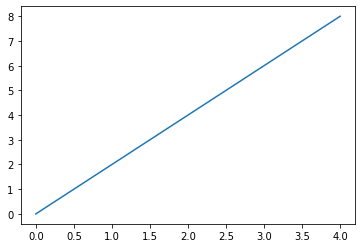

In [ ]:
# Q8. Are the gradients consistent with what you would expect from differentiating the function y = x^2?
# A8. Yes, it is 2*x

# Q9. Plot the graph for x and its gradients. Use detach() to detach them first
plt.plot(x.detach(), x.grad.detach())

In [ ]:
# Q10. What function is dy/dx based on the plot? Verify further by running this code.
x.grad == 2 * x


tensor([True, True, True, True, True])

## Autograd in NN Training

We've had a brief look at how autograd works, but how does it look when it's used for its intended purpose? Let's define a small model and examine how it changes after a single training batch. First, define a few constants, our model, and some stand-ins for inputs and outputs:

In [ ]:
BATCH_SIZE = 16
DIM_IN = 1000
HIDDEN_SIZE = 100
DIM_OUT = 10

class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()
        
        self.layer1 = torch.nn.Linear(1000, 100)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(100, 10)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x
    
some_input = torch.randn(BATCH_SIZE, DIM_IN, requires_grad=False)
ideal_output = torch.randn(BATCH_SIZE, DIM_OUT, requires_grad=False)

model = TinyModel()

In [ ]:
print(some_input)
print(ideal_output)

tensor([[ 1.9304, -1.2457,  1.0339,  ..., -0.1160, -1.0352,  0.9398],
        [-0.2501, -0.6918, -0.9016,  ...,  0.9595, -2.0047,  2.0555],
        [ 0.4270,  0.3835,  0.3447,  ..., -0.2208,  1.2392, -1.2151],
        ...,
        [-1.9973, -0.1665, -0.4906,  ...,  0.6130,  1.2908, -0.1482],
        [-0.2585, -0.9406, -0.9890,  ..., -0.9782, -0.3580,  0.8241],
        [ 0.9202, -0.3793, -0.4637,  ..., -0.9916, -0.9418,  0.2865]])
tensor([[-1.4091e+00, -7.5004e-01,  2.4802e+00, -1.3603e+00, -7.4882e-01,
         -8.9735e-01, -5.8766e-01, -1.1903e+00,  8.2312e-01,  5.0230e-01],
        [ 2.6934e-01,  9.1505e-01, -1.5358e+00,  1.6749e+00, -1.3865e+00,
          4.9982e-01, -1.4667e-01, -4.5258e-01, -4.9520e-02, -9.7466e-02],
        [-1.4456e-01, -1.9154e+00,  1.0807e+00,  8.8458e-01, -1.7586e+00,
          4.2036e-01, -5.3473e-01,  3.5452e-01, -7.2274e-01, -2.1599e-01],
        [-2.8546e+00,  1.1351e+00,  6.7895e-01,  8.2301e-01,  3.9248e-01,
          1.6994e+00, -4.7911e-01,  1.8219e+0

In [ ]:
#Q11. How many input units does this NN have?
# 1000 units.

#Q12. How many output units does it have?
# 10 units.

#Q13. How many hidden layers does it have?
# Just one hidden layer

One thing you might notice is that we never specify `requires_grad=True` for the model's layers. Within a subclass of `torch.nn.module`, it's assumed that we want to track gradients on the layers' weights for learning.

## Initial Parameter Values
If we look at the layers of the model, we can examine the values of the weights:

In [ ]:
model.layer2.weight[0]
# what does 'selectBackward' mean?

tensor([ 0.0715,  0.0673,  0.0757, -0.0967,  0.0454, -0.0573,  0.0704,  0.0432,
         0.0215,  0.0288, -0.0530,  0.0752, -0.0002, -0.0286, -0.0693,  0.0931,
        -0.0310, -0.0959,  0.0447, -0.0525,  0.0368, -0.0994, -0.0540,  0.0139,
         0.0445,  0.0082, -0.0560, -0.0362, -0.0729, -0.0066, -0.0837, -0.0324,
         0.0452, -0.0279,  0.0118,  0.0659,  0.0225,  0.0604,  0.0234, -0.0543,
         0.0475, -0.0197, -0.0974, -0.0250,  0.0828,  0.0413, -0.0682,  0.0486,
        -0.0131, -0.0216,  0.0246, -0.0758,  0.0495, -0.0192,  0.0297,  0.0628,
        -0.0365, -0.0618,  0.0607,  0.0314,  0.0016,  0.0549, -0.0123,  0.0110,
         0.0104, -0.0503,  0.0722,  0.0415,  0.0057, -0.0764, -0.0507, -0.0384,
         0.0824, -0.0812, -0.0141, -0.0595, -0.0101,  0.0177,  0.0653, -0.0148,
        -0.0606,  0.0904,  0.0922,  0.0556,  0.0125,  0.0033,  0.0809, -0.0464,
        -0.0467, -0.0682,  0.0046, -0.0879,  0.0765,  0.0975, -0.0523, -0.0471,
        -0.0569, -0.0546,  0.0038, -0.08

In [ ]:
print(f"Layer2 sample weights = \n{model.layer2.weight[0][0:10]}") # just a small slice
print(f"Layer2 sample bias = \n{model.layer2.bias[0]}") # just one bias

print("\nGradients:")
print(f"Weights = {model.layer2.weight.grad}")
print(f"Bias = {model.layer2.bias.grad}")


Layer2 sample weights = 
tensor([ 0.0715,  0.0673,  0.0757, -0.0967,  0.0454, -0.0573,  0.0704,  0.0432,
         0.0215,  0.0288], grad_fn=<SliceBackward0>)
Layer2 sample bias = 
-0.011381745338439941

Gradients:
Weights = None
Bias = None


In [ ]:
#Q14. Why are the gradients 'None' for the sample weights and bias?
#A14. Because we haven't call .backward() method yet.

## Forward Pass & Loss Calculation
Let's see how this changes when we run through one training batch. For a loss function, we'll just use the square of the Euclidean distance between our `prediction` and the `ideal_output` (MSE), and we'll use a basic stochastic gradient descent optimizer.

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

prediction = model(some_input)

loss = (ideal_output - prediction).pow(2).sum() # MSE
print(loss)

tensor(152.8475, grad_fn=<SumBackward0>)


## Backpropagating the Loss: `backward()`
Now, let's call `loss.backward()` and see what happens:

In [ ]:
loss.backward()
# Print the parameters
print("Parameters:")
print(f"Layer2 sample weights = {model.layer2.weight[0][0:10]}")
print(f"Layer2 sample bias = {model.layer2.bias[0]}")

# Print the gradients
print("\nGradients:")
print(f"Layer2 sample weight gradients = {model.layer2.weight.grad[0][0:10]}")
print(f"Layer2 sample bias gradient = {model.layer2.bias.grad[0]}")


Parameters:
Layer2 sample weights = tensor([ 0.0715,  0.0673,  0.0757, -0.0967,  0.0454, -0.0573,  0.0704,  0.0432,
         0.0215,  0.0288], grad_fn=<SliceBackward0>)
Layer2 sample bias = -0.011381745338439941

Gradients:
Layer2 sample weight gradients = tensor([-0.7557, -1.8322,  6.0227,  2.5740, -1.9469,  2.9355,  1.8538, -1.3650,
        -2.2657, -2.5952])
Layer2 sample bias gradient = 1.2641019821166992


In [ ]:
#Q15. Are the sample weights and bias the same as before the loss is backpropagated?
#A15. Yes, the weights are the same because, we do not train even one loop, just did backpropagation.  

#Q16. Are the gradients of the sample weights and bias the same as before the loss is backpropagated?
#A16. No, previously, it did not have any gradient but now we have gradient by calling loss.backward().

## Updating the Parameters with the Optimiser: `step()`
We can see that the gradients have been computed for each learning weight, but the weights remain unchanged, because we haven't run the optimiser yet. The optimiser is responsible for updating model weights based on the computed gradients.

In [ ]:
optimizer.step() # 한번의 loop를 돌린 개념

print("Parameter updates:")
print(f"Layer2 weights = {model.layer2.weight[0][0:10]}")
print(f"Layer2 bias = {model.layer2.bias[0]}")

print("\nGradients:")
print(f"Layer2 weight gradients = {model.layer2.weight.grad[0][0:10]}")
print(f"Layer2 bias gradients = {model.layer2.bias.grad[0]}")


Parameter updates:
Layer2 weights = tensor([ 0.0723,  0.0691,  0.0697, -0.0992,  0.0473, -0.0602,  0.0685,  0.0446,
         0.0238,  0.0314], grad_fn=<SliceBackward0>)
Layer2 bias = -0.012645847164094448

Gradients:
Layer2 weight gradients = tensor([-0.7557, -1.8322,  6.0227,  2.5740, -1.9469,  2.9355,  1.8538, -1.3650,
        -2.2657, -2.5952])
Layer2 bias gradients = 1.2641019821166992


You should see that `layer2`'s sample weights and bias have changed.

## Resetting the gradients: `zero_grad()`
One important thing about the process: After calling `optimizer.step()`, you need to call `optimizer.zero_grad()`, or else every time you run `loss.backward()`, the gradients on the learning weights will accumulate:

In [ ]:
print(f"Layer2 some weights: \n{model.layer2.weight[0][0:10]}")
print(f"Layer2 one bias: {model.layer2.bias[0]}")

for i in range(0, 5):
    prediction = model(some_input)
    loss = (ideal_output - prediction).pow(2).sum()
    loss.backward()
    
print("\nAfter a few iterations of training:")
print(f"Layer2 some weights GRADs: \n{model.layer2.weight.grad[0][0:10]}")
print(f"Layer2 one bias GRAD: {model.layer2.bias.grad[0]}")

optimizer.zero_grad()

print("\nAfter resetting gradients:")
print(f"Layer2 some weights = {model.layer2.weight.grad[0][0:10]}")
print(f"Layer2 one bias = {model.layer2.bias.grad[0]}")


Layer2 some weights: 
tensor([-0.0604, -0.0863,  0.0163, -0.0865, -0.0021,  0.0691, -0.0485, -0.0251,
         0.0605, -0.0264], grad_fn=<SliceBackward0>)
Layer2 one bias: -0.011091786436736584

After a few iterations of training:
Layer2 some weights GRADs: 
tensor([  0.0553,   0.9123, -12.7409,   5.8534, -15.0571,  -0.9653,  -4.8379,
         -7.7049,  -1.8245, -36.6950])
Layer2 one bias GRAD: -51.45423889160156

After resetting gradients:
Layer2 some weights = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Layer2 one bias = 0.0


In [ ]:
#Q17. Why are the gradients after running loss.backward() multiple times much bigger?
#A17. Because we did not put optimizer.zero_grad() method.


## Turning Autograd Off and On

There are situations where you will need fine-grained control over whether autograd is enabled. There are multiple ways to do this, depending on the situation.

The simplest is to change the `requires_grad` flag on a tensor directly:

In [ ]:
a = torch.ones(2, 3, requires_grad=True)
print(f'a = {a}')

b1 = 2 * a
print(f'b1 = {b1}')

a.requires_grad = False
b2 = 2 * a
print(f'b2 = {b2}')


a = tensor([[1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)
b1 = tensor([[2., 2., 2.],
        [2., 2., 2.]], grad_fn=<MulBackward0>)
b2 = tensor([[2., 2., 2.],
        [2., 2., 2.]])


In the cell above, we see that `b1` has a `grad_fn` (i.e., a traced computation history), which is what we expect, since it was derived from a tensor, `a`, that had autograd turned on. When we turn off autograd explicitly with `a.requires_grad = False`, computation history is no longer tracked, as we see when we compute `b2`.

If you only need autograd turned off temporarily, a better way is to use the `torch.no_grad()`:

In [ ]:
a = torch.ones(2, 3, requires_grad=True) * 2
b = torch.ones(2, 3, requires_grad=True) * 3

c1 = a + b
print(f"c1: \n{c1}")

with torch.no_grad():
    c2 = a + b

print(f"c2: \n{c2}")

c3 = a * b
print(f"c3: \n{c3}")

c1: 
tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)
c2: 
tensor([[5., 5., 5.],
        [5., 5., 5.]])
c3: 
tensor([[6., 6., 6.],
        [6., 6., 6.]], grad_fn=<MulBackward0>)


In [ ]:
#Q18. Can we do differentiation on computations on c1? Why?
#A18. Yes, since both a and b are tensor with 'requires_grad=True'.

#Q19. Can we do differentiation on computations on c2? Why?
#A19. No. C2 is computed with 'torch.no_grad()'.

#Q20. Can we do differentiation on computations on c3? Why?
#A19. Yes, since only c2 is done without tracking history temporarily.

`torch.no_grad()` can also be used as a function or method dectorator:

In [ ]:
def add_tensors1(x, y):
    return x + y

@torch.no_grad()
def add_tensors2(x, y):
    return x + y


a = torch.ones(2, 3, requires_grad=True) * 2
b = torch.ones(2, 3, requires_grad=True) * 3

c1 = add_tensors1(a, b)
print(c1)

c2 = add_tensors2(a, b)
print(c2)

tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)
tensor([[5., 5., 5.],
        [5., 5., 5.]])


There's a corresponding context manager, `torch.enable_grad()`, for turning autograd on when it isn't already. It may also be used as a decorator.

Finally, you may have a tensor that requires gradient tracking, but you want a copy that does not. For this we have the `Tensor` object's `detach()` method - it creates a copy of the tensor that is *detached* from the computation history:

In [ ]:
x = torch.rand(5, requires_grad=True)
y = x.detach()

print(x)
print(y)

tensor([0.3789, 0.4885, 0.1580, 0.3413, 0.2825], requires_grad=True)
tensor([0.3789, 0.4885, 0.1580, 0.3413, 0.2825])


We did this above when we wanted to graph some of our tensors. This is because `matplotlib` expects a NumPy array as input, and the implicit conversion from a PyTorch tensor to a NumPy array is not enabled for tensors with requires_grad=True. Making a detached copy lets us move forward.
